In [4]:
from mcmd.densities import Funnel, GaussianMixture
import matplotlib.pyplot as plt 
import numpy as np
import torch

In [ ]:
# Seaborn setup 
sns.set_style('white')

In [ ]:
import torch

class Test:
    def __init__(self) -> None:
        self.x = 10
        
    def run(self, y):
        return (self.x + y).mean()

test = Test()

def f(x):
    return test.run(x)

df = torch.func.grad(f)

df(torch.tensor([2.0], requires_grad=True))

In [2]:
from mcmd.sampler import CMCD
from mcmd.score import ResNet
from mcmd.densities import GaussianMixture, DoubleWell
from mcmd.anneal import GeometricAnnealing

import torch 
import torch.nn as nn 
from torch.distributions import MultivariateNormal
from main import GaussianVI

from mcmd.densities import Funnel, GaussianMixture
import matplotlib.pyplot as plt 
import numpy as np
import torch


INFO:2024-01-12 13:19:51 1100:1100 init.cpp:158] If you see CUPTI_ERROR_INSUFFICIENT_PRIVILEGES, refer to https://developer.nvidia.com/nvidia-development-tools-solutions-err-nvgpuctrperm-cupti


In [11]:
subtraj = dict(
    ln_w=[torch.tensor([0.6, 0.4]), torch.tensor([2.0, 2.3])],
    ln_phi=[torch.tensor([1.0, 3.0]), torch.tensor([2.0, 1.0]), torch.tensor([3.0, 2.0])]
)

discount = 1.05
ln_w = torch.vstack(subtraj["ln_w"])
ln_phi = torch.vstack(subtraj["ln_phi"])
sum_ln_w = ln_w.cumsum(dim=0)
loss = 0.0
norm = 0.0

for i in range(sum_ln_w.shape[0]):
    for j in range(i, sum_ln_w.shape[0]):
        w = sum_ln_w[j] - (sum_ln_w[i-1] if i > 0 else 0)
        print(i, j, w)
        w += ln_phi[j+1] - ln_phi[i]
        factor = discount ** (j - i + 1)
        norm += factor
        loss += factor * w.var()

print(sum_ln_w)

loss / norm

0 0 tensor([0.6000, 0.4000])
0 1 tensor([2.6000, 2.7000])
1 1 tensor([2.0000, 2.3000])
tensor([[0.6000, 0.4000],
        [2.6000, 2.7000]])


tensor(3.1411)

In [2]:
dw = DoubleWell(50, 5, 4)
dw.log_norm()

tensor(40.7620, device='cuda:0')

In [2]:
x = torch.tensor([[1.5, 1.5], [2.0, 2.0], [2.5, 2.5], [2.5, 1.0], [2.5, 0.9], [2.5, 3.0]])

a = 0.5
batch = int(x.shape[0] * a)
repel_x = x[: batch]
distance_m = torch.cdist(repel_x, repel_x) 
h_t = distance_m.flatten().median() ** 2 / torch.tensor(x.shape[0]).log()
d = (-(distance_m ** 2 / h_t)).exp()
f = (repel_x[:, None] - repel_x[None, :])

force = -(d[:, :, None] * f).sum(1) / (batch * h_t) 
x -  torch.nn.functional.pad(force, (0, 0, 0, x.shape[0] - batch), "constant", 0)

tensor([[1.3995, 1.3995],
        [2.0000, 2.0000],
        [2.6005, 2.6005],
        [2.5000, 1.0000],
        [2.5000, 0.9000],
        [2.5000, 3.0000]])

In [2]:

score_fn = ResNet(5, 36, 41, 32).cuda()

initial_dist = GaussianVI(5, 3.0).cuda()

target = DoubleWell(5, 5, 4)

anneal = GeometricAnnealing()

sampler = CMCD(initial_dist, target, anneal, score_fn, 32, 0.01).to('cuda')

optim = torch.optim.Adam(sampler.parameters(), lr=1e-1)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, T_0=100)

tensor(-0.6465, device='cuda:0', grad_fn=<SubBackward0>) tensor(108.3787, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5400, device='cuda:0')


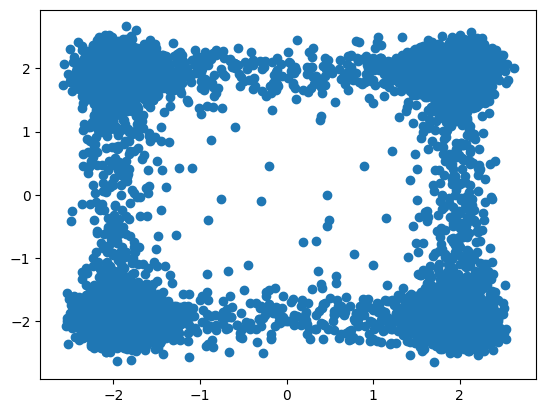

In [3]:
samples = sampler.sample(10000, loss_fn="mean", correct=False, repel=False, a=1.0)

print(samples.ln_z, samples.loss)
print(target.log_norm())

plt.scatter(samples.particles[:, 0].detach().cpu().numpy(), samples.particles[:, 1].detach().cpu().numpy())

In [4]:
samples = sampler.sample(10000, loss_fn="var", correct=False, repel=True, a=1.0)


print(samples.ln_z, samples.loss)
print(target.log_norm())

plt.scatter(samples.particles[:, 0].detach().cpu().numpy(), samples.particles[:, 1].detach().cpu().numpy())

KeyboardInterrupt: 

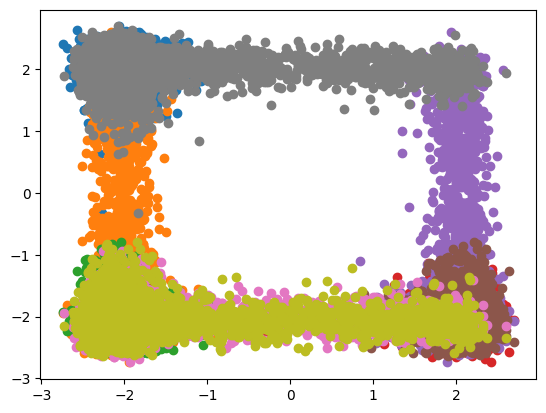

In [6]:
for i in range(3):
    for j in range(4):
        if i != j:
            plt.scatter(samples.particles[:, i].detach().cpu().numpy(), samples.particles[:, j].detach().cpu().numpy())

In [43]:
(sampler.repel(samples.particles)) * 0.01

tensor([[ 21.1661, -11.2077],
        [-34.0363,  28.3828],
        [ 34.9589,  31.2083],
        ...,
        [ 26.7869, -31.1697],
        [ 33.1269,  28.0406],
        [ -6.3147,  12.2653]], device='cuda:0')

In [16]:

import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-20, 20, 30)
y = np.linspace(-20, 20, 30)

X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
coords = torch.tensor(coords, dtype=torch.float32).cuda()

# %timeit sampler.drift(coords, 4).cpu().detach()
%timeit sampler.log_phi(coords, 6 / 8)



679 µs ± 135 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [6]:
sampler.score_fn

ResNet(
  (embed_timestep): Embedding(9, 38)
  (fc1): Sequential(
    (0): Linear(in_features=40, out_features=40, bias=False)
    (1): Softplus(beta=1, threshold=20)
  )
  (fc2): Sequential(
    (0): Linear(in_features=40, out_features=40, bias=False)
    (1): Softplus(beta=1, threshold=20)
  )
  (fc3): Linear(in_features=40, out_features=1, bias=False)
)

In [15]:


import torch._dynamo
torch._dynamo.config.suppress_errors = True

import numpy as np
import matplotlib.pyplot as plt

b = 10
s = 50
x = np.linspace(-b, b, s)
y = np.linspace(-b, b, s)

X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
coords = torch.tensor(coords, dtype=torch.float32).cuda()


# gg = (sampler.score_fn(coords, 4) * 10 ** 14 *  torch.nn.functional.normalize(sampler.grad_log_phi_(coords, 6, True), dim=1)).cpu().detach()
# gg = (sampler.drift(coords, 16)).cpu().detach()
gg = (-sampler.score_fn(coords, 20)).cpu().detach()


mag = torch.norm(gg, dim=1).reshape(s, s)

print(torch.norm(gg, dim=1).mean())
plt.figure(figsize=(10, 10))

plt.quiver(X, Y, gg[:, 0], gg[:, 1])
plt.contour(X, Y, mag)
plt.colorbar()

print(sampler.score_fn.scale)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2500x2 and 5x40)

In [28]:
x = torch.tensor([[1.0, 1.0], [2.0, 5.0], [4.0, 4.0]])

In [31]:
f = - 2 * (x[:, None] - x[None, :]).sum(1)
f

tensor([[  8.,  14.],
        [  2., -10.],
        [-10.,  -4.]])

In [35]:
d = (-(torch.cdist(x, x) ** 2)).exp().sum(1)
d

tensor([1.0000, 1.0067, 1.0067])

In [37]:
f * d[:, None]

tensor([[  8.0000,  14.0000],
        [  2.0135, -10.0674],
        [-10.0674,  -4.0270]])

: 

In [6]:
sampler.eps
sampler.betas()

tensor([0.0000, 0.1133, 0.2282, 0.3447, 0.4668, 0.6014, 0.7346, 0.8672, 1.0000],
       device='cuda:0', grad_fn=<DivBackward0>)

In [36]:
sampler.repel(samples.particles)

tensor([[-104.2496, -159.6876,  -80.5175,  138.0436,  144.3194],
        [ 476.0269, -313.0292,  -95.3671,   50.6934,   90.2740],
        [  96.1687,  -60.1733,  102.4588,  -53.8138,   88.1990],
        ...,
        [-581.6094,   49.6249,  174.5681,  101.2871, -179.0338],
        [  69.7600,  -13.3155,   60.1516,  -75.2948,   69.3456],
        [-196.7796,  126.5544, -155.2065, -140.9308,  199.4352]],
       device='cuda:0')

In [7]:
for i in range(10000):
    optim.zero_grad()
    samples = sampler.sample(3000, loss_fn="var", correct=False, repel=True, a=0.5)
    loss = samples.loss
    assert loss != None
    # if i % 20 == 0:
    loss.backward()
    # print(sampler.score_fn.scale)
    print(loss.item(), sampler.score_fn.scale.item(), samples.ln_z.item())
    # print(loss, samples.ln_z.item(), samples.elbo.item(), samples2.ln_z.item(), samples2.elbo.item())
    optim.step()
    scheduler.step()
    

863.7626953125 0.6763034462928772 -21.531513214111328
737.47705078125 0.6778823733329773 -8.125012397766113
681.7000122070312 0.677582859992981 -15.956802368164062
737.6953125 0.6754868626594543 -19.994365692138672
634.1867065429688 0.672622561454773 -6.399284362792969
686.1063232421875 0.6683309078216553 3.6713638305664062
695.5575561523438 0.662674069404602 2.135220527648926
661.6764526367188 0.6564545035362244 4.940072059631348
681.3248291015625 0.6494894027709961 5.675118446350098
718.325439453125 0.6424437165260315 10.876294136047363
630.697998046875 0.6353476047515869 5.090198516845703
694.0678100585938 0.6283784508705139 4.535120010375977
751.8439331054688 0.6219859719276428 -0.21898603439331055
698.22802734375 0.6165910363197327 3.4197778701782227
670.2063598632812 0.612275242805481 -6.064133167266846
667.8906860351562 0.609199583530426 -13.87520694732666
624.8118286132812 0.6072270274162292 -4.999173641204834
564.968017578125 0.6063967347145081 -19.040809631347656
508.02050781

KeyboardInterrupt: 

In [49]:
sampler.sample((500,), correct=False).ln_z

AUTOTUNE addmm(500x40, 500x40, 40x40)
  bias_addmm 0.0082 ms 100.0%
  addmm 0.0105 ms 78.3%
SingleProcess AUTOTUNE takes 0.2354 seconds
AUTOTUNE addmm(500x2, 500x40, 40x2)
  bias_addmm 0.0067 ms 100.0%
  addmm 0.0092 ms 72.6%
SingleProcess AUTOTUNE takes 0.2188 seconds
[2023-12-10 03:06:11,624] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (8)
[2023-12-10 03:06:11,624] torch._dynamo.convert_frame: [WARNING]    function: 'resume_in_step' (/home/brianlck/code/code/dissertation/mcmd/sampler.py:165)
[2023-12-10 03:06:11,624] torch._dynamo.convert_frame: [WARNING]    last reason: ___check_obj_id(L['correct'], 94027720832032)
[2023-12-10 03:06:11,624] torch._dynamo.convert_frame: [WARNING] To log all recompilation reasons, use TORCH_LOGS="recompiles".
[2023-12-10 03:06:11,624] torch._dynamo.convert_frame: [WARNING] To diagnose recompilation issues, see https://pytorch.org/docs/master/compile/troubleshooting.html.


tensor(-0.0200, device='cuda:0', grad_fn=<SubBackward0>)

In [ ]:
import torch.autograd.profiler as profiler

with profiler.profile(with_stack=True, profile_memory=True) as prof:
    samples = sampler.sample(10)

In [ ]:
print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=100))

In [118]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-50, 50, 10)
y = np.linspace(-50, 50, 10)

X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
coords = torch.tensor(coords, dtype=torch.float32).cuda()

score = -score_fn(coords, 2).detach().cpu()
mag = torch.norm(score, dim=1).reshape(10, 10)

plt.quiver(X, Y, score[:, 0], score[:, 1])
plt.contour(X, Y, mag)
plt.colorbar()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x37 and 40x40)

In [5]:

x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
coords = torch.tensor(coords, dtype=torch.float32)

score = sampler.grad_log_phi(coords, 6 / 8).detach()
mag = torch.norm(score, dim=1).reshape(100, 100)

score = score / mag.reshape(-1, 1)

densities = dw.log_density(coords).reshape(100, 100).exp()

plt.figure(figsize=(20, 20))
plt.quiver(X, Y, score[:, 0], score[:, 1])
plt.colorbar()

NameError: name 'np' is not defined

In [7]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
coords = torch.tensor(coords, dtype=torch.float32)


score = torch.func.jacrev(lambda x: target.log_density(x).mean())(coords).detach()
mag = torch.norm(score, dim=1).reshape(100, 100)

densities = target.log_density(coords).reshape(100, 100).exp()

score = score / mag.reshape(-1, 1)

plt.figure(figsize=(20, 20))

plt.quiver(X, Y, score[:, 0], score[:, 1])
plt.contour(X, Y, densities)
plt.colorbar()

NameError: name 'target' is not defined

tensor(-0.2365, dtype=torch.float64)
tensor(-0.2168, device='cuda:0')


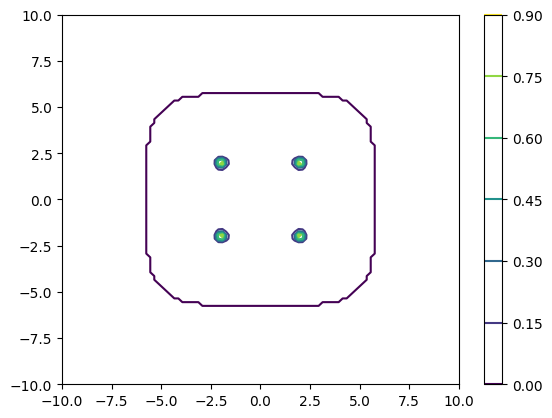

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mcmd.densities import DoubleWell
import torch

dw = DoubleWell(2, 2, 4)

n = 100
b = 10
x = np.linspace(-b, b, n)
y = np.linspace(-b, b, n)

X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
coords = torch.tensor(coords, device='cuda')

density = dw.log_density(coords).reshape(n, n).T.exp().cpu()

cum = (density.sum() * (2 * b / n) * (2 * b / n)).log()

print(cum)
print(dw.log_norm())

plt.contour(X, Y, density)
plt.colorbar()

In [7]:
DoubleWell(5, 5, 4).log_norm()


tensor(-0.5424, device='cuda:0')

In [3]:
import torch
dw.log_density(torch.tensor([[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]))

tensor([1.2664e-14, 1.2664e-14, 1.2664e-14, 1.2664e-14, 1.2664e-14, 1.2664e-14,
        1.2664e-14])

In [ ]:
score_fn(coords[:2], 1)

In [ ]:
score_fn(coords[:2], 2)